<a href="https://colab.research.google.com/github/Suraez/nepali-news-headline-generator/blob/main/nepaliNews.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [53]:
import pickle
def load_headline_from_file():
    with open('/content/output.pkl', 'rb') as file:
        lst = pickle.load(file)
    return lst

In [ ]:
headlineList = load_headline_from_file()
print('\n'.join([headline for headline in headlineList]))

In [3]:
def view_dataset(dataset):
  print('\n'.join([headline for headline in dataset]))

In [4]:
headlineList[0]

'नीति तथा कार्यक्रम : स्वास्थ्यका के-के विषय समेटिए\xa0?'

In [5]:
import string
def clean_dataset():
    processed_sentences = []
    for sentence in headlineList:
        # Remove punctuation
        sentence = sentence.translate(str.maketrans('', '', string.punctuation))
        # Remove double spaces
        sentence = ' '.join(sentence.split())
        processed_sentences.append(sentence)
    return processed_sentences

In [6]:
cleanedHeadlines = clean_dataset()

In [ ]:
view_dataset(cleanedHeadlines)

In [8]:
from keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer()

In [9]:
tokenizer.fit_on_texts(cleanedHeadlines)

In [10]:
wordVocab = tokenizer.word_index

In [12]:
def create_data_sequence():
  data_sequence=[]
  for headline in cleanedHeadlines:
    tempSequence = tokenizer.texts_to_sequences([headline])[0]
    for i in range(1, len(tempSequence)):
      data_sequence.append(tempSequence[:i+1])

  return data_sequence

In [13]:
data_sequence = create_data_sequence()

In [15]:
def pad_data_sequence():
  maxLengthDataSequence = max([len(sequence) for sequence in data_sequence])
  for sequence in data_sequence:
    padding_size = maxLengthDataSequence - len(sequence)
    padding = [0] * padding_size
    sequence[:0] = padding


In [16]:
pad_data_sequence()

In [17]:
import numpy as np

input_output_tensor = np.array(data_sequence)
print(input_output_tensor.shape)

(194, 13)


In [18]:
input_tensor = input_output_tensor[:, :-1]
output_tensor = input_output_tensor[:,-1]

In [19]:
input_tensor.shape

(194, 12)

In [21]:
output_tensor.shape

(194,)

In [ ]:
output_tensor

In [24]:
import tensorflow as tf
output_tensor = tf.keras.utils.to_categorical(output_tensor, len(wordVocab) + 1)

In [25]:
input_tensor.shape

(194, 12)

In [27]:
from keras import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout

vocabLen = len(wordVocab) + 1

model = Sequential()
model.add(Embedding(vocabLen, 100, input_length=12))
model.add(Dense(100))
model.add(LSTM(100))
model.add(Dropout(0.2))
model.add(Dense(vocabLen, activation="softmax"))

model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=['accuracy'])

In [ ]:
history = model.fit(input_tensor, output_tensor, epochs=100, verbose=1, validation_split=0.2)

###Plotting the model performance

In [58]:
accuracyList = history.history['accuracy']
valAccuracyList = history.history['val_accuracy']
loss = history.history['loss']
valLoss = history.history['val_loss']

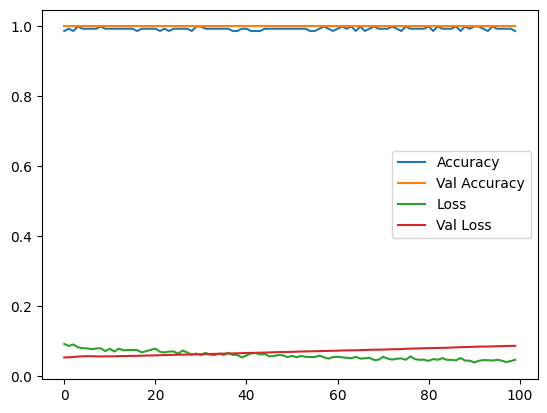

In [59]:
from matplotlib import pyplot as plt

plt.plot(accuracyList)
plt.plot(valAccuracyList)
plt.plot(loss)
plt.plot(valLoss)
plt.legend(['Accuracy', 'Val Accuracy', 'Loss', 'Val Loss'])
plt.show()

###Prediction Part

In [42]:
def get_padded_seqeunce(seed_text):
  # cleaning the sentence
  sentence = seed_text.translate(str.maketrans('', '', string.punctuation))
  sentence = ' '.join(sentence.split())
  #generate sequence of known words in the vocabulary
  sentence_sequence = tokenizer.texts_to_sequences([sentence])[0]
  maxLengthDataSequence = max([len(sequence) for sequence in data_sequence])
  padding_size = maxLengthDataSequence - len(sentence_sequence) - 1
  padding = [0] * padding_size
  sentence_sequence[:0] = padding
  return sentence_sequence


In [68]:
def generate_headline(seed_text, lengthOfNews, model):

  while len(seed_text.split(' ')) < lengthOfNews:
    textPaddedSequence = get_padded_seqeunce(seed_text)
    predictedIndex = np.argmax(model.predict([textPaddedSequence], verbose=0))
    for word, index in wordVocab.items():
      if index == predictedIndex:
        seed_text += " " + word

  return seed_text








In [69]:
generate_headline('शरणार्थीको विषय जनता', 10, model)

'शरणार्थीको विषय जनता स्थानीय तहबाटै सरकारी सेवा अनलाइनमार्फत प्रवाह गरिने'

###Saving the model part

In [60]:
pwd

'/content'

In [61]:
model.save('/content/nepali_news_headline_model.hdf5')

In [65]:
loaded_model = tf.keras.models.load_model('/content/nepali_news_headline_model.hdf5')
loaded_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 12, 100)           17700     
                                                                 
 dense_2 (Dense)             (None, 12, 100)           10100     
                                                                 
 lstm_1 (LSTM)               (None, 100)               80400     
                                                                 
 dropout_1 (Dropout)         (None, 100)               0         
                                                                 
 dense_3 (Dense)             (None, 177)               17877     
                                                                 
Total params: 126,077
Trainable params: 126,077
Non-trainable params: 0
_________________________________________________________________


### Now predictin with the help of loaded model

In [71]:
paddedSequence = get_padded_seqeunce('काम नगर्ने ठेकेदारलाई')
predictedIndex = np.argmax(loaded_model.predict([paddedSequence], verbose=0))
predictedIndex

146

In [72]:
generate_headline('काम नगर्ने ठेकेदारलाई', 10, loaded_model)

'काम नगर्ने ठेकेदारलाई दुई सिफ्टमा गराइने गराइने गराइने गराइने आविष्कार'